## DEFINITION OF THE MODEL, TRAINING PHASE,GENERATION OF PREDICTED MASKS


This code get the 80/20 split from the input dataframe: "dataframe_1" to the output dataframe "dataframe_2"

Then define and train a segmentation model based on the existing UNet and visualize a random predicted mask.


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import libs
import os
import time
import cv2
from tqdm import tqdm
import numpy as np
import skimage.draw
import random

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.io as sio
from PIL import Image
import scipy
import scipy.ndimage

K = tf.keras.backend

# Set the backend for segmentation-models to use tf.keras
os.environ['SM_FRAMEWORK'] = 'tf.keras'

!pip install segmentation-models
import segmentation_models as sm

!pip install split-folders

In [4]:
%cd /content/drive/MyDrive/Colab_Notebooks/PROGETTO

/content/drive/MyDrive/Colab_Notebooks/PROGETTO


# DEFINITION OF DATALOADER AND UTILITY FUNCTIONS + SPLIT DATASET: TRAIN AND VALIDATION

---



DEFINITION OF UTILITY FUNCTIONS

DEFINITION OF DATASE: SPLIT INTO TRAIN AND VALIDATION

In [ ]:
# Create folders
def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)



# Helper function for data visualization
def visualize(**images):
    """PLot images in one row."""

    norm=plt.Normalize(0,4) # 5 classes including BG
    # Define colors directly for legend consistency
    colors = ["black", "red","yellow","blue", "green"]
    map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=map_name, norm=norm)


# Helper function for data visualization
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x


# Classes for data loading and preprocessing
class Dataset:
    """Read images, apply augmentation and preprocessing transformations.

    Args:
        images_path (str): path to images folder
        masks_path (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline

    """

    CLASSES = ['Epithelial', 'Lymphocyte', 'Neutrophil', 'Macrophage', 'unlabelled']

#REMEMBER:
#    label_map = {'Epithelial':1, RED
#             'Lymphocyte':2, YELLOW
#             'Macrophage':4, GREEN
#             'Neutrophil':3, BLUE
#            }


    def __init__(
            self,
            images_path,
            masks_path,
            classes=None,
            augmentation=None,

    ):
        #list of image's name
        self.ids = os.listdir(images_path)

        # Sorted list
        self.images_fps = sorted([os.path.join(images_path, image_id) for image_id in self.ids])
        self.masks_fps = sorted([os.path.join(masks_path, image_id) for image_id in self.ids])


        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) for cls in classes] # cls used instead of cls.lower()

    def __getitem__(self, i):

        # Read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_fps[i], 0)

        # Extract certain classes from mask
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype(np.float32) # Convert to float32 explicitly for the loss function

        # Add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)

        return image, mask

    def __len__(self):
        return len(self.ids) #lunghezza del dataset


class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(
            self, dataset, batch_size=1, shuffle=False, **kwargs):
        super().__init__(**kwargs) # Call the parent class constructor
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # Transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


##DEFINITION OF DATASE: SPLIT INTO TRAIN AND VALIDATION

In [6]:
import splitfolders

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

IN_FOLDER = os.path.join(ROOT_DIR, "dataframe_1")
OUT_FOLDER = os.path.join(ROOT_DIR, "dataframe_2")
IN_FOLDER, OUT_FOLDER

# Split with a ratio.
splitfolders.ratio(IN_FOLDER, output=OUT_FOLDER, seed=1337, ratio=(.8, .2)) # default values

Copying files: 418 files [01:59,  3.50 files/s]


In [7]:
# Define paths
initial_cwd = os.getcwd()
dataset_path = os.path.join(initial_cwd, 'dataframe_2')
experiment_name='exp.1'
log_path = os.path.join(initial_cwd, "logs", experiment_name)
create_directory(log_path)

# Get the data

# Training data
x_train_dir = os.path.join(dataset_path, 'train', 'images')
y_train_dir = os.path.join(dataset_path, 'train', 'masks')

# Validation data
x_valid_dir = os.path.join(dataset_path, 'val', 'images')
y_valid_dir = os.path.join(dataset_path, 'val', 'masks')

##check class distribution

In [8]:
# Define class labels (matching the Dataset class)
CLASS_LABELS = ['Background','Epithelial', 'Lymphocyte', 'Neutrophil', 'Macrophage']

def get_mask_class_presence(mask_path, class_labels):
    """Analyzes a mask file to determine which classes are present."""
    mask = cv2.imread(mask_path, 0) # Read as grayscale
    unique_pixels = np.unique(mask)
    classes_present = []
    for pixel_value in unique_pixels:
        if 0 <= pixel_value < len(class_labels):
            classes_present.append(class_labels[pixel_value])
    return classes_present
    print(classes_present)

def analyze_mask_directory(mask_dir, class_labels):
    """Analyzes all masks in a directory and returns a DataFrame of class presence."""
    data = []
    mask_filenames = sorted(os.listdir(mask_dir))
    for filename in mask_filenames:
        full_path = os.path.join(mask_dir, filename)
        if os.path.isfile(full_path):
            classes_in_mask = get_mask_class_presence(full_path, class_labels)
            data.append({'filename': filename, 'classes_present': classes_in_mask})
    return pd.DataFrame(data)


In [9]:
import pandas as pd

# Analyze training masks
train_df = analyze_mask_directory(y_train_dir, CLASS_LABELS)

# Analyze validation masks
val_df = analyze_mask_directory(y_valid_dir, CLASS_LABELS)

print("Train DataFrame head:")
display(train_df.head())

print("\nValidation DataFrame head:")
display(val_df.head())


Train DataFrame head:


,filename,classes_present
0,TCGA-55-1594-01Z-00-DX1_001.tif,"[Background, Epithelial, Lymphocyte]"
1,TCGA-55-1594-01Z-00-DX1_002.tif,"[Background, Lymphocyte]"
2,TCGA-55-1594-01Z-00-DX1_003.tif,"[Background, Lymphocyte, Macrophage]"
3,TCGA-55-1594-01Z-00-DX1_004.tif,"[Background, Lymphocyte, Neutrophil]"
4,TCGA-5P-A9K0-01Z-00-DX1_1.tif,"[Background, Epithelial, Macrophage]"



Validation DataFrame head:


,filename,classes_present
0,TCGA-55-1594-01Z-00-DX1_005.tif,"[Background, Epithelial, Lymphocyte]"
1,TCGA-73-4668-01Z-00-DX1_001.tif,"[Background, Lymphocyte, Neutrophil, Macrophage]"
2,TCGA-86-7713-01Z-00-DX1_004.tif,"[Background, Epithelial, Lymphocyte]"
3,TCGA-86-8672-01Z-00-DX1_3.tif,"[Background, Epithelial, Lymphocyte, Neutrophil]"
4,TCGA-B6-A0WZ-01Z-00-DX1_2.tif,"[Background, Macrophage]"


In [10]:
# Function to calculate and print class distribution from 'classes_present' column
def print_class_distribution(df, dataset_name="Dataset"):
    all_classes = []
    for classes_list in df['classes_present']:
        all_classes.extend(classes_list)

    # Convert to pandas Series to use value_counts
    class_series = pd.Series(all_classes)

    print(f"\nClass distribution in {dataset_name}:")
    # Filter out 'Background' for more relevant cellular class distribution
    distribution = class_series[class_series != 'Background'].value_counts(normalize=True)
    print(distribution)

# Print distributions
print_class_distribution(train_df, "training set")
print_class_distribution(val_df, "validation set")

# Print dataset sizes
print(f"\nTraining dataset size: {len(train_df)} images")
print(f"Validation dataset size: {len(val_df)} images")


Class distribution in training set:
Lymphocyte    0.366559
Epithelial    0.241158
Neutrophil    0.237942
Macrophage    0.154341
Name: proportion, dtype: float64

Class distribution in validation set:
Lymphocyte    0.361446
Epithelial    0.337349
Neutrophil    0.180723
Macrophage    0.120482
Name: proportion, dtype: float64

Training dataset size: 167 images
Validation dataset size: 42 images


## Visualize random images and corresponding masks from the training dataset

(149, 288, 3) (149, 288, 5)
(624, 734, 3) (624, 734, 5)
(109, 90, 3) (109, 90, 5)


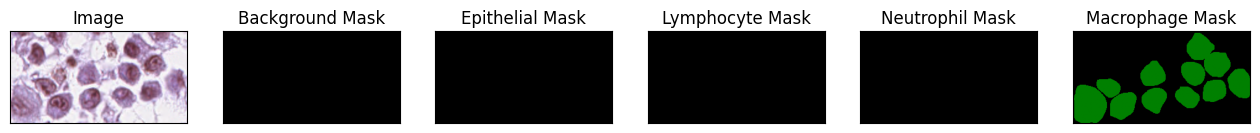

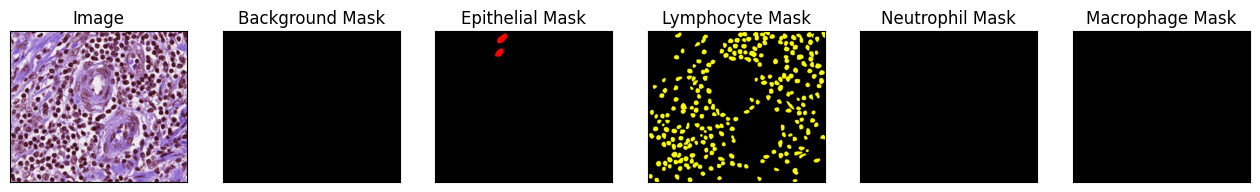

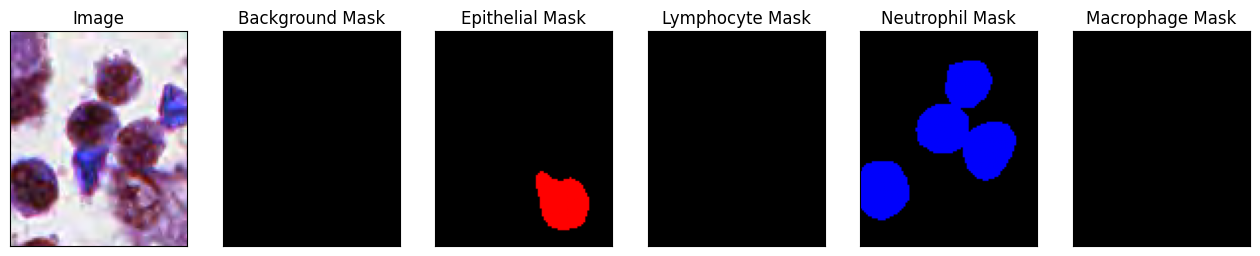

In [11]:
#label_map = {'Epithelial':1 - red,
#         'Lymphocyte':2 - yellow,
#         'Macrophage':4 - blue,
#         'Neutrophil':3 - green,
#        }
# to change the colors, go in the first cells and change in the definition of function 'visualize'

cells = ['Epithelial', 'Lymphocyte', 'Neutrophil', 'Macrophage']

dataset = Dataset(x_train_dir, y_train_dir, classes=cells)

for i in range(3):

    image, mask = dataset[random.randrange(len(dataset))] # get some sample
    print(image.shape, mask.shape)

    visualize(
        image=image,
        background_mask = mask[..., 0].squeeze() * 0, # Unlabelled/Background (original value 0) -> black
        Epithelial_mask = mask[..., 1].squeeze() * 1, # Epithelial (original value 1) -> red
        Lymphocyte_mask = mask[..., 2].squeeze() * 2, # Lymphocyte (original value 2) -> yellow
        Neutrophil_mask = mask[..., 3].squeeze() * 3, # Neutrophil (original value 3) -> blue
        Macrophage_mask = mask[..., 4].squeeze() * 4  # Macrophage (original value 4) -> green
    )


#### Augmentations

    resize
    horizontal and vertical flip
    rotation
    color jitter
    image bluring and sharpening
    gaussian noise addition
    random crops

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


(256, 256, 3) (256, 256, 5)
(256, 256, 3) (256, 256, 5)
(256, 256, 3) (256, 256, 5)


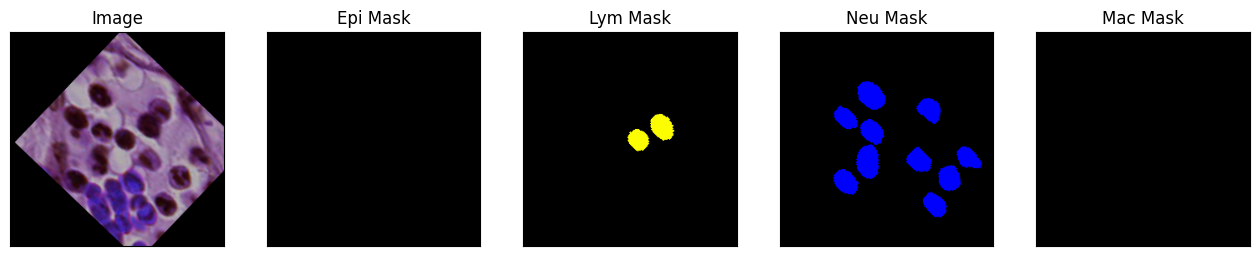

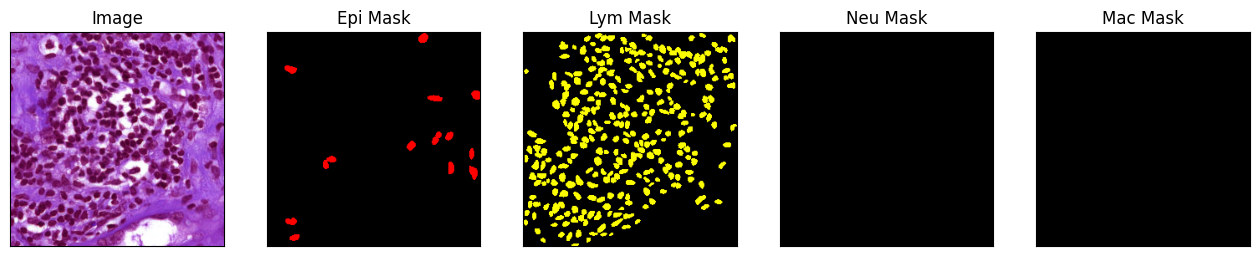

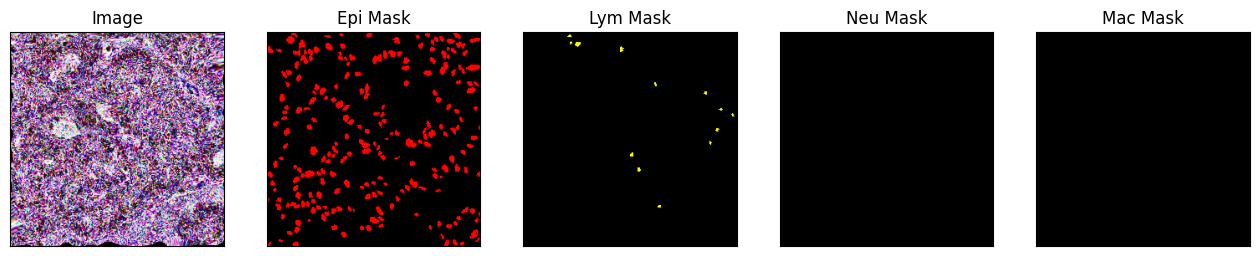

In [12]:
import albumentations as A
patchsize=256

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define augmentations
train_transforms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Resize(height=patchsize, width=patchsize),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=90, shift_limit=0.1, p=0.5, border_mode=0),

        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        A.GaussNoise(p=0.2),
        A.ElasticTransform(p=0.5, alpha=120, sigma=6),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1),
                A.RandomGamma(p=1),
                ],
            p=0.9,
            ),
])


val_transforms = A.Compose([
        A.Resize(height=256, width=256),
])

# visualize random images and corresponding masks after augmentation
dataset = Dataset(x_train_dir, y_train_dir, classes=cells, augmentation=train_transforms)

for i in range(3):
    image, mask = dataset[random.randrange(len(dataset))]
    print(image.shape, mask.shape)
    visualize(
        image=image,
        epi_mask=mask[..., 1].squeeze()*1,
        lym_mask=mask[..., 2].squeeze()*2,
        neu_mask=mask[..., 3].squeeze()*3,
        mac_mask=mask[..., 4].squeeze()*4,
    )

# Build and compile network

### Dynamic calculation of class weights

In [49]:
#dynamically calculate class weights based on the frequency of pixels of each class in the training masks

# Initialise pixel counts for each foreground class (from 1 to 4)
pixel_counts_per_class = {cls_val: 0 for cls_val in range(1, len(CLASS_LABELS))} # exclude background (0)

total_foreground_pixels = 0
print(f"Calculate class weights in: {y_train_dir}")

mask_files = sorted(os.listdir(y_train_dir))
if not mask_files:
    print("No masks found in the training directory. Unable to calculate class weights.")
    calculated_class_weight_array = np.ones(len(cells)) * 1.0
else:
    for mask_filename in mask_files:
        mask_path = os.path.join(y_train_dir, mask_filename)
        mask = cv2.imread(mask_path, 0)

        if mask is None:
            print(f"Unable to read the mask file {mask_path}. Skipped.")
            continue


        flattened_mask = mask.flatten()

        # count pixels for each class
        for cls_val in range(1, len(CLASS_LABELS)):
            count = np.sum(flattened_mask == cls_val)
            pixel_counts_per_class[cls_val] += count
            total_foreground_pixels += count

    print("\nTotal pixel counts per foreground class:")
    for cls_val, count in pixel_counts_per_class.items():
        print(f"  {CLASS_LABELS[cls_val]} ( pixel value {cls_val}): {count} pixel")

    if total_foreground_pixels == 0:
        print("No foreground pixels found in the masks. All class weights set to 1.0.")
        calculated_class_weight_array = np.ones(len(cells)) * 1.0
    else:
        #Calculate weights based on the inverse of frequency
        # A higher weight is assigned to less frequent classes.

        weights_list = []
        for class_name_in_CLASSES in cells:
            pixel_value = CLASS_LABELS.index(class_name_in_CLASSES)
            count = pixel_counts_per_class.get(pixel_value, 0)

            if count > 0:
                frequency = count / total_foreground_pixels
                weights_list.append(1.0 / frequency)
            else:
                 # If a class is not present in any mask, assign a default weight (e.g. 1.0)
                weights_list.append(1.0)

        calculated_class_weight_array = np.array(weights_list)

        # Normalise weights to a reasonable scale, for example, average to 1.0.
        non_zero_weights = calculated_class_weight_array[calculated_class_weight_array > 0]
        if len(non_zero_weights) > 0:
            mean_weight = np.mean(non_zero_weights)
            calculated_class_weight_array = calculated_class_weight_array / mean_weight
        else:
            calculated_class_weight_array = np.ones(len(cells)) * 1.0

print("\nCalculated final class weights (for classes in the order of CLASSES):")
print(calculated_class_weight_array)

#MODIFICATION AFTER 1st try
# Create a copy for modification
modified_class_weight_array = np.copy(calculated_class_weight_array)

# Identify indices for 'Lymphocyte' and 'Macrophage' using the 'cells' list
# to match the indexing of 'modified_class_weight_array'
lymphocyte_idx = cells.index('Lymphocyte')
macrophage_idx = cells.index('Macrophage')

# Decrease weights for 'Lymphocyte' and 'Macrophage'
# Using factors 0.5 and 0.7 as examples to reduce their influence
modified_class_weight_array[lymphocyte_idx] *= 0.5
modified_class_weight_array[macrophage_idx] *= 0.7

# Re-normalize the modified array
non_zero_modified_weights = modified_class_weight_array[modified_class_weight_array > 0]
if len(non_zero_modified_weights) > 0:
    mean_modified_weight = np.mean(non_zero_modified_weights)
    modified_class_weight_array = modified_class_weight_array / mean_modified_weight
else:
    modified_class_weight_array = np.ones(len(cells)) * 1.0 # Fallback if all weights are zero

print(f"Modified and re-normalized class weights: {modified_class_weight_array}")

Calculate class weights in: /content/drive/MyDrive/Colab_Notebooks/PROGETTO/dataframe_2/train/masks

Total pixel counts per foreground class:
  Epithelial ( pixel value 1): 6756110 pixel
  Lymphocyte ( pixel value 2): 3405982 pixel
  Neutrophil ( pixel value 3): 269194 pixel
  Macrophage ( pixel value 4): 1391893 pixel

Calculated final class weights (for classes in the order of CLASSES):
[0.12145115 0.24091065 3.0481264  0.58951179]
Modified and re-normalized class weights: [0.13120311 0.13012733 3.29287677 0.44579279]


In [21]:
BACKBONE = 'resnet50'
BATCH_SIZE = 16
CLASSES = cells
LR = 1e-4   # 0.0001
EPOCHS = 100
new_class_weight = np.array([0.5, 0.3, 2, 2])
preprocess_input = sm.get_preprocessing(BACKBONE)


# Define network parameters
n_classes = (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'softmax' #for multiclass segmentation

# Create model
# Set encoder_weights to downloading pre-trained weight
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation,encoder_weights='imagenet')

# Define optomizer
optim = keras.optimizers.Adam(LR)

# Use the dynamically calculated class_weight_array
class_weight_array = new_class_weight

# calc loss over the 4 classes
class_index_array =  np.array([1,2,3,4])


dice_loss_fn = sm.losses.DiceLoss(class_weights = class_weight_array, class_indexes = class_index_array)
jacard_loss_fn = sm.losses.JaccardLoss(class_weights = class_weight_array, class_indexes = class_index_array)
focal_loss_fn = sm.losses.CategoricalFocalLoss(alpha=0.25, gamma=2.0, class_indexes = class_index_array) #default value of alpha and gamma


# Define weights for each loss. These are hyperparameters to tune.
w_focal = 0.8  # Weight for Focal Loss
w_jacard = 1.5 # Weight for Jaccard Loss
w_dice = 1.5 # Weight for Dice Loss

# Combine the losses into a single callable function
def combined_loss(y_true, y_pred):
    total_loss = (w_focal * focal_loss_fn(y_true, y_pred)) + \
                 (w_jacard * jacard_loss_fn(y_true, y_pred)) + \
                 (w_dice * dice_loss_fn(y_true, y_pred))
    # Return the loss twice to match the expected number of loss_weights
    return [total_loss, total_loss]

# Define metrics
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Compile model with defined optimozer, loss and metrics
# To address the 'ValueError: `loss_weights` must match the number of losses, got 1 losses and 2 weights.'
# we provide the same combined_loss twice and set loss_weights accordingly.
# This is a common workaround for specific internal behaviors of segmentation_models.
model.compile(optim, loss=[combined_loss, combined_loss], metrics=metrics, loss_weights=[1.0, 1.0])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, None,      │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_36   │ (None, None,      │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, None,      │      9,408 │ zero_padding2d_3… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, None,      │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, None,      │          0 │ bn0[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_37   │ (None, None,      │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, None,      │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, None,      │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, None,      │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, None,      │      4,096 │ stage1_unit1_rel… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, None,      │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_38   │ (None, None,      │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, None,      │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn3    │ (None, None,      │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu3  │ (None, None,      │          0 │ stage1_unit1_bn3

 Total params: 32,561,694 (124.21 MB)

 Trainable params: 32,514,136 (124.03 MB)

 Non-trainable params: 47,558 (185.77 KB)

In [22]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    classes=CLASSES,
    augmentation=train_transforms,
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    classes=CLASSES ,
    augmentation=val_transforms,
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, patchsize, patchsize, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, patchsize, patchsize, n_classes)


# Define callbacks for learning rate scheduling, logging and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('{}/{}.h5'.format(log_path, experiment_name), monitor='val_loss', save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, verbose=1, patience=5, mode='min'), ## new_lr = lr * factor # 5
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=15, mode='min', restore_best_weights=True), # 8
    keras.callbacks.CSVLogger('{}/training.csv'.format(log_path))
]


# Test train loader
x , y = next(iter(valid_dataloader))
print(x.shape, y.shape)

(16, 256, 256, 3) (16, 256, 256, 5)


## Training the model

In [23]:
# Train model

start_time = time.time()

history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader),  # val samples = batch size * no of steps
)

end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - f1-score: 0.0348 - iou_score: 0.0181 - loss: 2.8425 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 395s 35s/step - f1-score: 0.0352 - iou_score: 0.0183 - loss: 2.8425 - softmax_loss: 0.0000e+00 - val_f1-score: 0.0100 - val_iou_score: 0.0051 - val_loss: 2.8696 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.0539 - iou_score: 0.0295 - loss: 2.8160 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 373s 34s/step - f1-score: 0.0553 - iou_score: 0.0304 - loss: 2.8125 - softmax_loss: 0.0000e+00 - val_f1-score: 0.0194 - val_iou_score: 0.0102 - val_loss: 2.8490 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.0900 - iou_score: 0.0522 - loss: 2.7346 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 354s 35s/step - f1-score: 0.0899 - iou_score: 0.0521 - loss: 2.7338 - softmax_loss: 0.0000e+00 - val_f1-score: 0.0220 - val_iou_score: 0.0116 - val_loss: 2.8246 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - f1-score: 0.1275 - iou_score: 0.0729 - loss: 2.6690 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 357s 35s/step - f1-score: 0.1277 - iou_score: 0.0731 - loss: 2.6698 - softmax_loss: 0.0000e+00 - val_f1-score: 0.0389 - val_iou_score: 0.0222 - val_loss: 2.7835 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.1726 - iou_score: 0.1038 - loss: 2.6170 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 367s 34s/step - f1-score: 0.1717 - iou_score: 0.1032 - loss: 2.6186 - softmax_loss: 0.0000e+00 - val_f1-score: 0.0814 - val_iou_score: 0.0498 - val_loss: 2.7350 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - f1-score: 0.2005 - iou_score: 0.1212 - loss: 2.5029 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 368s 36s/step - f1-score: 0.1980 - iou_score: 0.1197 - loss: 2.5074 - softmax_loss: 0.0000e+00 - val_f1-score: 0.1521 - val_iou_score: 0.1053 - val_loss: 2.6783 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - f1-score: 0.1866 - iou_score: 0.1112 - loss: 2.4860 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 360s 35s/step - f1-score: 0.1865 - iou_score: 0.1114 - loss: 2.4849 - softmax_loss: 0.0000e+00 - val_f1-score: 0.1236 - val_iou_score: 0.0782 - val_loss: 2.6450 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.1756 - iou_score: 0.1040 - loss: 2.5219 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 374s 35s/step - f1-score: 0.1756 - iou_score: 0.1040 - loss: 2.5198 - softmax_loss: 0.0000e+00 - val_f1-score: 0.1131 - val_iou_score: 0.0678 - val_loss: 2.6192 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 369s 34s/step - f1-score: 0.1686 - iou_score: 0.1004 - loss: 2.5088 - softmax_loss: 0.0000e+00 - val_f1-score: 0.1281 - val_iou_score: 0.0746 - val_loss: 2.6362 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.2170 - iou_score: 0.1349 - loss: 2.3303 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 385s 34s/step - f1-score: 0.2174 - iou_score: 0.1350 - loss: 2.3315 - softmax_loss: 0.0000e+00 - val_f1-score: 0.1316 - val_iou_score: 0.0801 - val_loss: 2.5913 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.2515 - iou_score: 0.1550 - loss: 2.2601 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 383s 34s/step - f1-score: 0.2496 - iou_score: 0.1535 - loss: 2.2683 - softmax_loss: 0.0000e+00 - val_f1-score: 0.1562 - val_iou_score: 0.0894 - val_loss: 2.5597 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 333s 32s/step - f1-score: 0.2808 - iou_score: 0.1738 - loss: 2.2554 - softmax_loss: 0.0000e+00 - val_f1-score: 0.1410 - val_iou_score: 0.0825 - val_loss: 2.5619 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.2882 - iou_score: 0.1822 - loss: 2.2033 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 350s 35s/step - f1-score: 0.2879 - iou_score: 0.1819 - loss: 2.2060 - softmax_loss: 0.0000e+00 - val_f1-score: 0.1573 - val_iou_score: 0.0946 - val_loss: 2.5413 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 362s 33s/step - f1-score: 0.2926 - iou_score: 0.1813 - loss: 2.2141 - softmax_loss: 0.0000e+00 - val_f1-score: 0.1663 - val_iou_score: 0.0968 - val_loss: 2.5606 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.3017 - iou_score: 0.1891 - loss: 2.2318 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 346s 35s/step - f1-score: 0.3019 - iou_score: 0.1890 - loss: 2.2309 - softmax_loss: 0.0000e+00 - val_f1-score: 0.2431 - val_iou_score: 0.1438 - val_loss: 2.4438 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 16/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 366s 33s/step - f1-score: 0.3238 - iou_score: 0.2059 - loss: 2.1547 - softmax_loss: 0.0000e+00 - val_f1-score: 0.2719 - val_iou_score: 0.1607 - val_loss: 2.4578 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 17/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.3521 - iou_score: 0.2271 - loss: 2.0066 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 336s 34s/step - f1-score: 0.3504 - iou_score: 0.2259 - loss: 2.0134 - softmax_loss: 0.0000e+00 - val_f1-score: 0.2918 - val_iou_score: 0.1747 - val_loss: 2.4006 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 18/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - f1-score: 0.3398 - iou_score: 0.2166 - loss: 2.0852 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 356s 35s/step - f1-score: 0.3396 - iou_score: 0.2165 - loss: 2.0865 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3072 - val_iou_score: 0.1930 - val_loss: 2.2828 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 19/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 354s 33s/step - f1-score: 0.3584 - iou_score: 0.2303 - loss: 1.9835 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3649 - val_iou_score: 0.2289 - val_loss: 2.3427 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 20/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 380s 32s/step - f1-score: 0.2841 - iou_score: 0.1773 - loss: 2.3001 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3478 - val_iou_score: 0.2193 - val_loss: 2.3346 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 21/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.3215 - iou_score: 0.2058 - loss: 2.1493 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 399s 34s/step - f1-score: 0.3233 - iou_score: 0.2070 - loss: 2.1417 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3179 - val_iou_score: 0.1946 - val_loss: 2.2651 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 22/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 332s 32s/step - f1-score: 0.3627 - iou_score: 0.2359 - loss: 1.9109 - softmax_loss: 0.0000e+00 - val_f1-score: 0.2816 - val_iou_score: 0.1676 - val_loss: 2.4140 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 23/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 332s 33s/step - f1-score: 0.3451 - iou_score: 0.2201 - loss: 2.0400 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3276 - val_iou_score: 0.1978 - val_loss: 2.3927 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 24/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.3878 - iou_score: 0.2574 - loss: 1.7898 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 345s 35s/step - f1-score: 0.3867 - iou_score: 0.2565 - loss: 1.7969 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3602 - val_iou_score: 0.2230 - val_loss: 2.2055 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 25/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 368s 33s/step - f1-score: 0.3638 - iou_score: 0.2395 - loss: 1.9363 - softmax_loss: 0.0000e+00 - val_f1-score: 0.2910 - val_iou_score: 0.1725 - val_loss: 2.3477 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 26/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.3621 - iou_score: 0.2358 - loss: 1.8994 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 344s 35s/step - f1-score: 0.3635 - iou_score: 0.2371 - loss: 1.8916 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3392 - val_iou_score: 0.2111 - val_loss: 2.1363 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 27/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.4073 - iou_score: 0.2702 - loss: 1.7168 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 384s 35s/step - f1-score: 0.4062 - iou_score: 0.2696 - loss: 1.7195 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4169 - val_iou_score: 0.2777 - val_loss: 1.8420 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 28/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 367s 33s/step - f1-score: 0.3918 - iou_score: 0.2621 - loss: 1.7368 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3722 - val_iou_score: 0.2331 - val_loss: 2.0646 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 29/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 327s 33s/step - f1-score: 0.4452 - iou_score: 0.3058 - loss: 1.4796 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3645 - val_iou_score: 0.2307 - val_loss: 2.0163 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 30/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 376s 32s/step - f1-score: 0.4070 - iou_score: 0.2743 - loss: 1.6295 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3541 - val_iou_score: 0.2223 - val_loss: 2.0888 - val_softmax_loss: 0.0000e+00 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 341s 34s/step - f1-score: 0.3882 - iou_score: 0.2583 - loss: 1.7454 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3904 - val_iou_score: 0.2540 - val_loss: 1.8263 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 33/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 368s 33s/step - f1-score: 0.3975 - iou_score: 0.2689 - loss: 1.6258 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3184 - val_iou_score: 0.1942 - val_loss: 2.2344 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 34/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 330s 33s/step - f1-score: 0.3916 - iou_score: 0.2643 - loss: 1.6800 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3344 - val_iou_score: 0.2086 - val_loss: 2.1057 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 35/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 376s 33s/step - f1-score: 0.3788 - iou_score: 0.2584 - loss: 1.7123 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3445 - val_iou_score: 0.2155 - val_loss: 2.0676 - val_softmax_loss: 0.0000e+00 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 345s 35s/step - f1-score: 0.4049 - iou_score: 0.2720 - loss: 1.6207 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3819 - val_iou_score: 0.2503 - val_loss: 1.8044 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 37/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 337s 33s/step - f1-score: 0.4171 - iou_score: 0.2856 - loss: 1.5249 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3371 - val_iou_score: 0.2120 - val_loss: 1.9956 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 38/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 334s 34s/step - f1-score: 0.4488 - iou_score: 0.3083 - loss: 1.4061 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3782 - val_iou_score: 0.2394 - val_loss: 1.8851 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 39/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 327s 33s/step - f1-score: 0.3983 - iou_score: 0.2683 - loss: 1.6353 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3336 - val_iou_score: 0.2053 - val_loss: 2.1213 - val_softmax_loss: 0.0000e+00 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 341s 34s/step - f1-score: 0.4568 - iou_score: 0.3228 - loss: 1.3418 - softmax_loss: 0.0000e+00 - val_f1-score: 0.3928 - val_iou_score: 0.2541 - val_loss: 1.7552 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 46/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.4565 - iou_score: 0.3243 - loss: 1.3246 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 391s 35s/step - f1-score: 0.4568 - iou_score: 0.3241 - loss: 1.3249 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4070 - val_iou_score: 0.2668 - val_loss: 1.6952 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 47/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.4609 - iou_score: 0.3220 - loss: 1.2957 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 357s 35s/step - f1-score: 0.4608 - iou_score: 0.3220 - loss: 1.2967 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4128 - val_iou_score: 0.2722 - val_loss: 1.6592 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 48/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - f1-score: 0.4485 - iou_score: 0.3156 - loss: 1.3717 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 344s 34s/step - f1-score: 0.4474 - iou_score: 0.3144 - loss: 1.3803 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4152 - val_iou_score: 0.2742 - val_loss: 1.6481 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 49/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 365s 33s/step - f1-score: 0.4415 - iou_score: 0.3063 - loss: 1.4404 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4144 - val_iou_score: 0.2732 - val_loss: 1.6528 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 50/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 378s 32s/step - f1-score: 0.4618 - iou_score: 0.3246 - loss: 1.2986 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4073 - val_iou_score: 0.2664 - val_loss: 1.6903 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 51/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 384s 32s/step - f1-score: 0.4719 - iou_score: 0.3303 - loss: 1.2330 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4081 - val_iou_score: 0.2674 - val_loss: 1.6856 - val_softmax_loss: 0.0000e+00 -

10/10 ━━━━━━━━━━━━━━━━━━━━ 332s 33s/step - f1-score: 0.4685 - iou_score: 0.3342 - loss: 1.2516 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4168 - val_iou_score: 0.2746 - val_loss: 1.6475 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 61/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 378s 33s/step - f1-score: 0.4693 - iou_score: 0.3310 - loss: 1.2912 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4168 - val_iou_score: 0.2745 - val_loss: 1.6477 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 62/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.4710 - iou_score: 0.3339 - loss: 1.2480 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 405s 36s/step - f1-score: 0.4708 - iou_score: 0.3337 - loss: 1.2499 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4173 - val_iou_score: 0.2750 - val_loss: 1.6455 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 63/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - f1-score: 0.4891 - iou_score: 0.3497 - loss: 1.1595 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 375s 35s/step - f1-score: 0.4873 - iou_score: 0.3482 - loss: 1.1689 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4186 - val_iou_score: 0.2762 - val_loss: 1.6391 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 64/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.4529 - iou_score: 0.3240 - loss: 1.3077 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 350s 34s/step - f1-score: 0.4532 - iou_score: 0.3239 - loss: 1.3080 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4194 - val_iou_score: 0.2770 - val_loss: 1.6351 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 65/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.4263 - iou_score: 0.3030 - loss: 1.4482 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 351s 34s/step - f1-score: 0.4290 - iou_score: 0.3046 - loss: 1.4365 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4194 - val_iou_score: 0.2770 - val_loss: 1.6350 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 66/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.4669 - iou_score: 0.3310 - loss: 1.2562 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 366s 35s/step - f1-score: 0.4658 - iou_score: 0.3299 - loss: 1.2624 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4205 - val_iou_score: 0.2780 - val_loss: 1.6280 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 67/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.4552 - iou_score: 0.3183 - loss: 1.3285 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 362s 35s/step - f1-score: 0.4557 - iou_score: 0.3190 - loss: 1.3264 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4212 - val_iou_score: 0.2786 - val_loss: 1.6259 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 68/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 340s 33s/step - f1-score: 0.4927 - iou_score: 0.3521 - loss: 1.1312 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4211 - val_iou_score: 0.2785 - val_loss: 1.6265 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 69/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - f1-score: 0.4513 - iou_score: 0.3139 - loss: 1.3682 - softmax_loss: 0.0000e+00 

10/10 ━━━━━━━━━━━━━━━━━━━━ 386s 35s/step - f1-score: 0.4521 - iou_score: 0.3147 - loss: 1.3635 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4219 - val_iou_score: 0.2792 - val_loss: 1.6242 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 70/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 333s 32s/step - f1-score: 0.4633 - iou_score: 0.3285 - loss: 1.2738 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4212 - val_iou_score: 0.2785 - val_loss: 1.6273 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 71/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 375s 33s/step - f1-score: 0.4740 - iou_score: 0.3373 - loss: 1.2492 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4202 - val_iou_score: 0.2775 - val_loss: 1.6328 - val_softmax_loss: 0.0000e+00 - learning_rate: 1.0000e-07
Epoch 72/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 322s 32s/step - f1-score: 0.4629 - iou_score: 0.3245 - loss: 1.3075 - softmax_loss: 0.0000e+00 - val_f1-score: 0.4206 - val_iou_score: 0.2779 - val_loss: 1.6302 - val_softmax_loss: 0.0000e+00 -

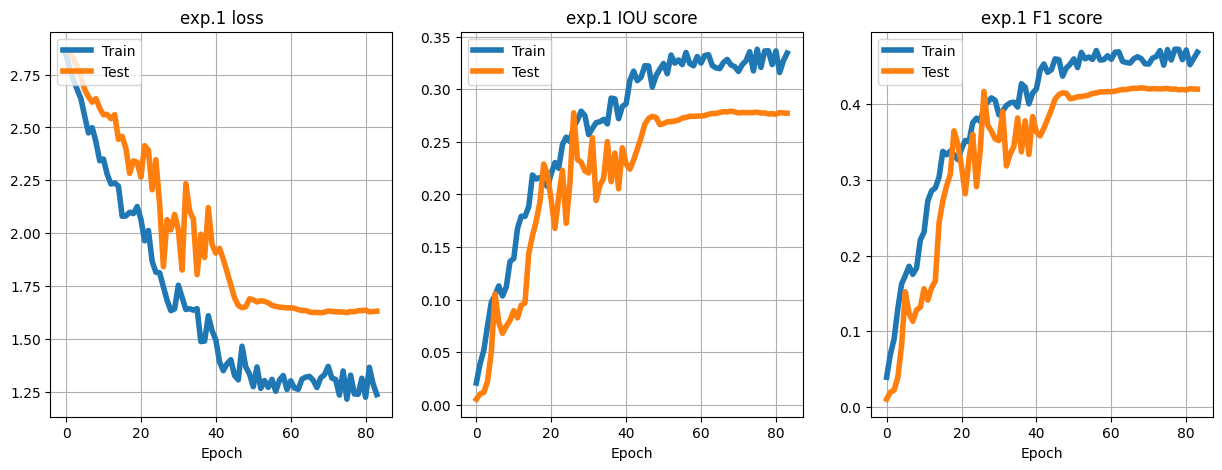

In [24]:
# Plot training & validation loss values
# b, g, r, y, o, -g, -m,

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(history.history['loss'],linewidth=4)
plt.plot(history.history['val_loss'],linewidth=4)
plt.title('{} loss'.format(experiment_name))
#plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)

# Plot training & validation iou_score values

plt.subplot(132)
plt.plot(history.history['iou_score'],linewidth=4)
plt.plot(history.history['val_iou_score'],linewidth=4)
plt.title('{} IOU score'.format(experiment_name))
#plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values

plt.subplot(133)
plt.plot(history.history['f1-score'],linewidth=4)
plt.plot(history.history['val_f1-score'],linewidth=4)
plt.title('{} F1 score'.format(experiment_name))
#plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(True)
plt.savefig('{}/{}_graph.png'.format(log_path, experiment_name), dpi=300)
plt.show()

## Model Evaluation

In [29]:
# Validation data is test data here

valid_dataset = Dataset(
    x_valid_dir,
    y_valid_dir,
    classes=CLASSES,
    augmentation=val_transforms, # Rimossa la chiamata () qui
)

valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

In [30]:
# Load best weights
#model=None
model.load_weights('{}/{}.h5'.format(log_path, experiment_name))

print("Model loaded")


# Run on validation set
scores = model.evaluate(valid_dataloader, verbose=1)


mean_scores = []

# Print scores
print("Loss: {:.5}".format(scores[0]))
mean_scores.append(scores[0])

for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))
    mean_scores.append(value)


Model loaded
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 540ms/step - f1-score: 0.4310 - iou_score: 0.3951 - loss: 2.7221 - softmax_loss: 0.0000e+00
Loss: 2.675
mean iou_score: 0.42474
mean f1-score: 0.46171


#### Visualization of results on test dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
(1, 256, 256, 3) (256, 256, 5) (1, 256, 256, 5)
Uniques in label and predicted [0 1 2] [1 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
(1, 256, 256, 3) (256, 256, 5) (1, 256, 256, 5)
Uniques in label and predicted [0 1 2] [1 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
(1, 256, 256, 3) (256, 256, 5) (1, 256, 256, 5)
Uniques in label and predicted [0 4] [0 1 2 4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
(1, 256, 256, 3) (256, 256, 5) (1, 256, 256, 5)
Uniques in label and predicted [0 1 2] [1 2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
(1, 256, 256, 3) (256, 256, 5) (1, 256, 256, 5)
Uniques in label and predicted [0 2 3] [0 1 2 3]


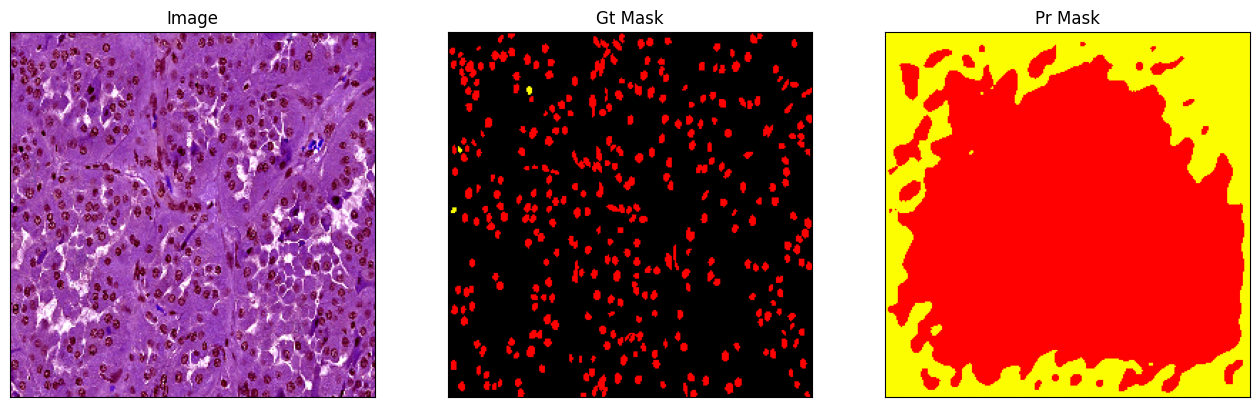

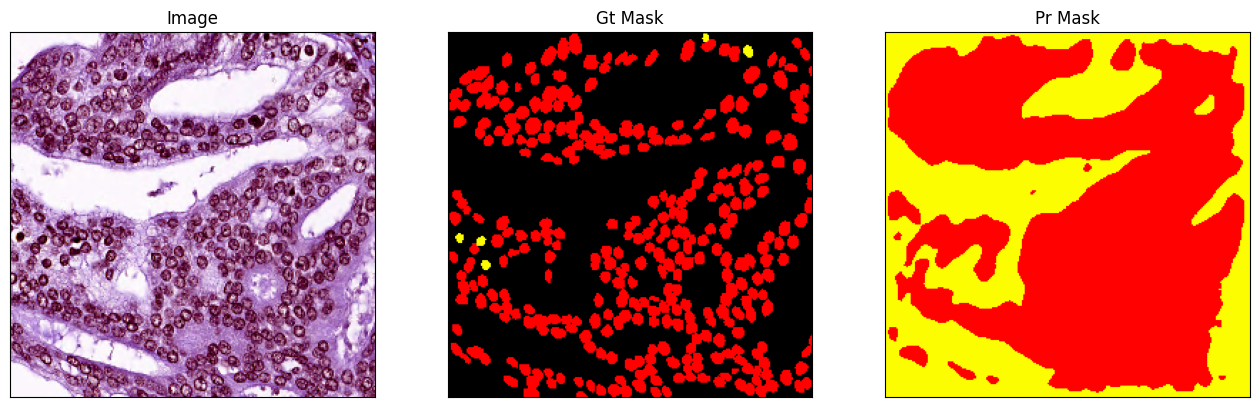

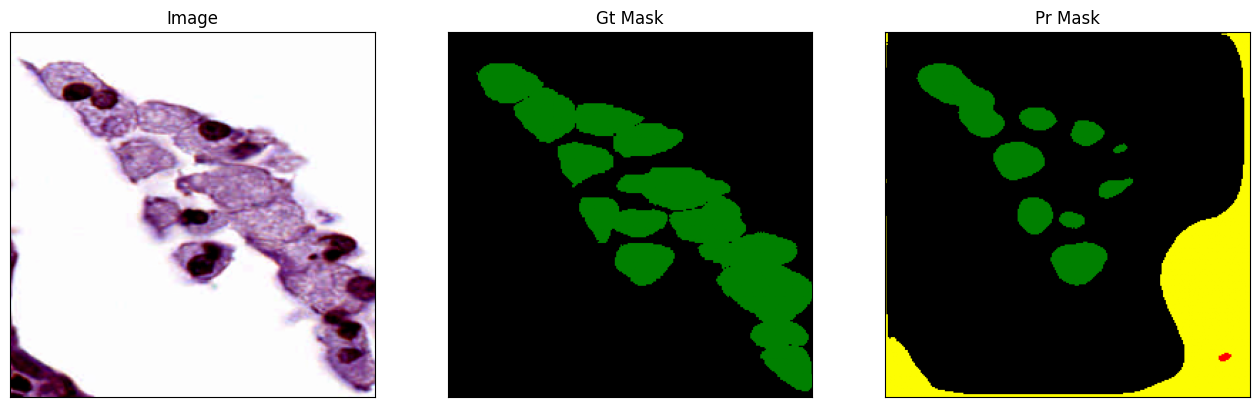

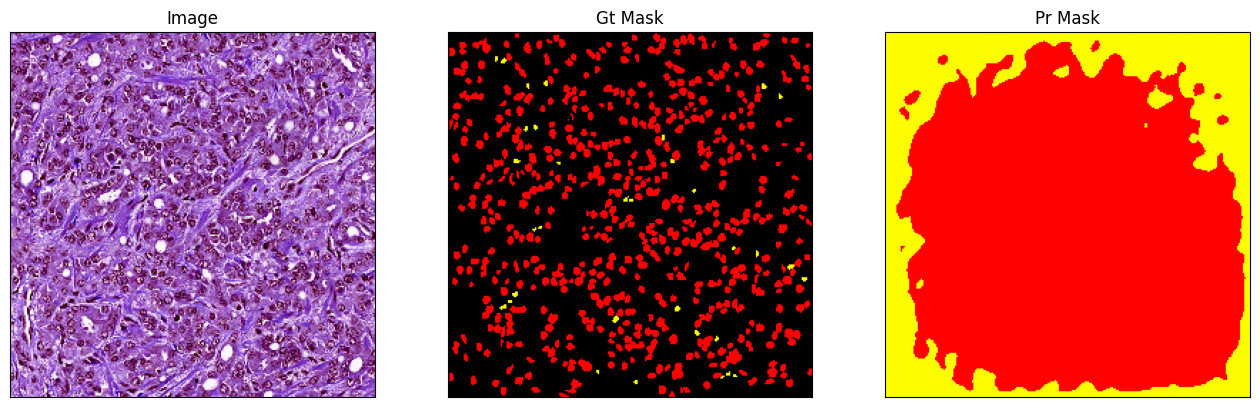

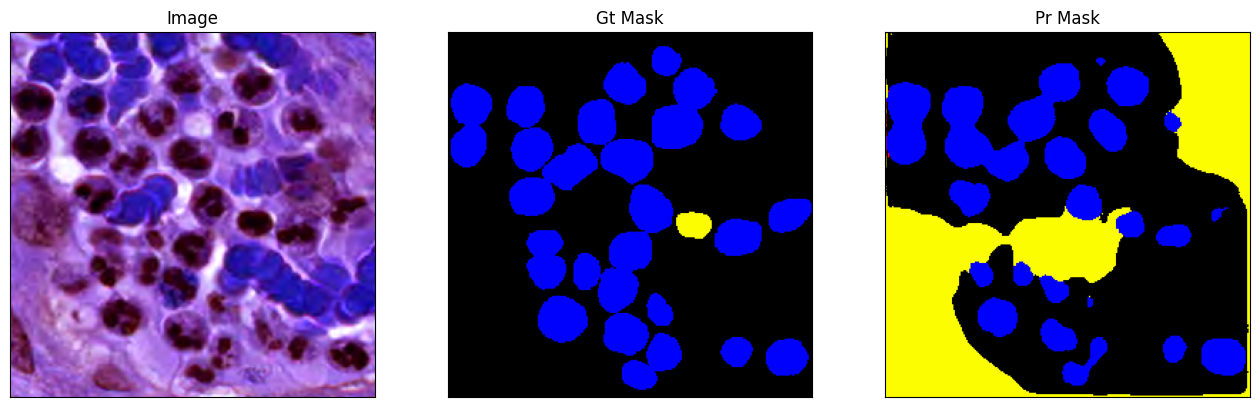

In [33]:
n = 5
ids = np.random.choice(np.arange(len(valid_dataset)), size=n)

for i in ids:

    image, gt_mask = valid_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)

    print(image.shape, gt_mask.shape, pr_mask.shape)

    gt_mask = np.argmax(gt_mask.squeeze(), axis=-1)
    pr_mask = np.argmax(pr_mask.squeeze(), axis=-1)
    print("Uniques in label and predicted", np.unique(gt_mask), np.unique(pr_mask))

    visualize(
        image=denormalize(image.squeeze()),
        #image= image.squeeze(),
        gt_mask = gt_mask,
        pr_mask = pr_mask
    )

#### Compute mean PQ on validation set

In [34]:
# Compute Panoptic quality metric for each image
def Panoptic_quality(ground_truth_image,predicted_image):
    TP = 0
    FP = 0
    FN = 0
    sum_IOU = 0
    matched_instances = {}# Create a dictionary to save ground truth indices in keys and predicted matched instances as velues
                        # It will also save IOU of the matched instance in [indx][1]

    # Find matched instances and save it in a dictionary
    for i in np.unique(ground_truth_image):
        if i == 0:
            pass
        else:
            temp_image = np.array(ground_truth_image)
            temp_image = temp_image == i
            matched_image = temp_image * predicted_image

            for j in np.unique(matched_image):
                if j == 0:
                    pass
                else:
                    pred_temp = predicted_image == j
                    intersection = sum(sum(temp_image*pred_temp))
                    union = sum(sum(temp_image + pred_temp))
                    IOU = intersection/union
                    if IOU> 0.5:
                        matched_instances [i] = j, IOU

    # Compute TP, FP, FN and sum of IOU of the matched instances to compute Panoptic Quality

    pred_indx_list = np.unique(predicted_image)
    pred_indx_list = np.array(pred_indx_list[1:])

    # Loop on ground truth instances
    for indx in np.unique(ground_truth_image):
        if indx == 0:
            pass
        else:
            if indx in matched_instances.keys():
                pred_indx_list = np.delete(pred_indx_list, np.argwhere(pred_indx_list == [indx][0]))
                TP = TP+1
                sum_IOU = sum_IOU+matched_instances[indx][1]
            else:
                FN = FN+1
    FP = len(np.unique(pred_indx_list))
    PQ = sum_IOU/(TP+0.5*FP+0.5*FN)

    return PQ

In [35]:
pqs = []
pqs_f = []

for i in tqdm(range(len(valid_dataset))):

    image, gt_mask = valid_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)

    gt_mask = np.argmax(gt_mask.squeeze(), axis=-1)
    pr_mask = np.argmax(pr_mask.squeeze(), axis=-1)

    # Post processing to refine predictions
    pred_filt = cv2.medianBlur(pr_mask.astype(np.uint8), 5)
    pred_filt = pred_filt.astype(np.uint8)

    pq = Panoptic_quality(gt_mask, pr_mask)
    pqf = Panoptic_quality(gt_mask, pred_filt)

    pqs.append(pq)
    pqs_f.append(pqf)


pqs = np.mean(np.array(pqs))
pqs_f = np.mean(np.array(pqs_f))

mean_scores.append(pqs)
mean_scores.append(pqs_f)

print("Mean PQ without filer: {:.3}".format( pqs))
print("Mean PQ without filer: {:.3}".format( pqs_f))

  0%|          | 0/42 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


  2%|▏         | 1/42 [00:00<00:30,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


  5%|▍         | 2/42 [00:01<00:25,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step


  7%|▋         | 3/42 [00:02<00:27,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 10%|▉         | 4/42 [00:02<00:29,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


 12%|█▏        | 5/42 [00:03<00:27,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 14%|█▍        | 6/42 [00:04<00:26,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step


 17%|█▋        | 7/42 [00:06<00:35,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step


 19%|█▉        | 8/42 [00:07<00:40,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 21%|██▏       | 9/42 [00:08<00:35,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


 24%|██▍       | 10/42 [00:09<00:30,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 26%|██▌       | 11/42 [00:09<00:25,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 29%|██▊       | 12/42 [00:10<00:23,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 31%|███       | 13/42 [00:10<00:21,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 33%|███▎      | 14/42 [00:11<00:20,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 36%|███▌      | 15/42 [00:12<00:19,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 38%|███▊      | 16/42 [00:13<00:18,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step


 40%|████      | 17/42 [00:13<00:16,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 43%|████▎     | 18/42 [00:14<00:15,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


 45%|████▌     | 19/42 [00:15<00:15,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 48%|████▊     | 20/42 [00:15<00:14,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


 50%|█████     | 21/42 [00:16<00:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


 52%|█████▏    | 22/42 [00:16<00:12,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


 55%|█████▍    | 23/42 [00:17<00:12,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step


 57%|█████▋    | 24/42 [00:19<00:16,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


 60%|█████▉    | 25/42 [00:20<00:17,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 62%|██████▏   | 26/42 [00:21<00:14,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step


 64%|██████▍   | 27/42 [00:21<00:12,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


 67%|██████▋   | 28/42 [00:22<00:10,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step


 69%|██████▉   | 29/42 [00:23<00:10,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


 71%|███████▏  | 30/42 [00:23<00:09,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 74%|███████▍  | 31/42 [00:24<00:07,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


 76%|███████▌  | 32/42 [00:25<00:07,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 79%|███████▊  | 33/42 [00:26<00:06,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


 81%|████████  | 34/42 [00:26<00:06,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step


 83%|████████▎ | 35/42 [00:27<00:05,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


 86%|████████▌ | 36/42 [00:28<00:04,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


 88%|████████▊ | 37/42 [00:28<00:03,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


 90%|█████████ | 38/42 [00:29<00:02,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


 93%|█████████▎| 39/42 [00:30<00:02,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


 95%|█████████▌| 40/42 [00:31<00:01,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


 98%|█████████▊| 41/42 [00:32<00:00,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step


100%|██████████| 42/42 [00:33<00:00,  1.24it/s]

Mean PQ without filer: 0.063
Mean PQ without filer: 0.0571
